---
# <font color="DarkBlue"><b><center>Redes Neuronales</center></b></font>
---
## <font color="DarkGreen"><center>Tarea 2: Dataset Breast Cancer Winsconsin (Original)</font>

**Realizado por:** David Cevallos<br>
**Fecha:** 2023-07-13

**Enlace Google Colab:**
https://colab.research.google.com/drive/1GYhFC8l4m7GvtLpAdIULtzYFD-TgK4tC

En esta tarea analizaremos el dataset Breast Cancer Wisconsin (Original) mediante árboles de decisión y la estrategia k-folding cross validation.

Se debe tener cargado el fichero de nombre breast-cancer-wisconsin.data en la carpeta home previo a la ejecución del notebook.

El dataset se encuentra disponible en:
https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

Consta de 9 descriptores y 699 observaciones. Comprende un problema de clasificación binaria.


In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn import tree
import sklearn.metrics as mt
import imblearn.metrics as imt
import matplotlib.pyplot as plt
import seaborn as sns

# Parte 1: Importación y limpieza de datos

# Función para redefinir valores de etiquetas
# 0 Benigno, 1 Maligno
# Tomaremos como referencia de clase positiva a 1 (Maligno)
def etiquetar(s):
  if s == 2:
    return 0
  return 1

# Función para corregir valores inconsistentes encontrados en el dataset
def corregir(s):
  if s == "?":
    return 1
  return int(s)

# Lectura de datos desde el archivo
data = pd.read_csv("/home/breast-cancer-wisconsin.data", header=None)

# Se presenta en pantalla inconsistencias encontradas respecto a los valores únicos
# que toman las columnas 6 y 10
print("--Antes de limpieza de datos")
print(data.dtypes)
print(np.unique(data[6]))
print(np.unique(data[10]))

# Resultados después de la limpieza de datos
print("--Después de limpieza de datos")
data[6] = data[6].map(lambda s: corregir(s))
y = data[10].map(lambda s: etiquetar(s)).to_numpy()
x = data.drop(columns=[0,10]).to_numpy()

# Se presenta en pantalla el resultado final de la limpieza de datos
print(np.unique(x[:,5].reshape(1,-1)))
print(np.unique(y))


--Antes de limpieza de datos
0      int64
1      int64
2      int64
3      int64
4      int64
5      int64
6     object
7      int64
8      int64
9      int64
10     int64
dtype: object
['1' '10' '2' '3' '4' '5' '6' '7' '8' '9' '?']
[2 4]
--Después de limpieza de datos
[ 1  2  3  4  5  6  7  8  9 10]
[0 1]


En el siguiente apartado de código definimos la función calcularMetricas para obtener los valores de métricas. Esta función es similar a la implementada en Matlab en clase.

In [2]:
# Función general para calcular métricas
# (Esta función es similar a la implementada en clase en Matlab para los ejemplos
# de PlayGolf, Tratamiento y Fisheriris)
# Calcula los valores de métricas y despliega la matriz de confusión y curva ROC
def calcularMetricas(ytrue, ypred):
  print("Matriz de confusión")
  cm = mt.confusion_matrix(ytrue, ypred)
  labels = ["Benigno","Maligno"]

  # Si se desea se puede observar la matriz en forma no gráfica
  # pd_cm = pd.DataFrame(cm,
  #            columns=labels,
  #            index=labels)
  # print(pd_cm)

  # Desplegamos matriz de confusión de forma gráfica
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    square=True,
    cmap="Blues",
    linewidths=0.2,
    annot_kws={"fontsize":12})
  ax.set_xlabel("Categoría predecida", fontsize=8)
  ax.set_ylabel("Categoría verdadera", fontsize=8)
  ax.xaxis.set_ticklabels(labels, fontsize=8)
  ax.yaxis.set_ticklabels(labels, fontsize=8)
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=8)
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)
  plt.show()

  # Obtenemos las métricas correspondientes
  precision = mt.precision_score(ytrue, ypred)
  recall = mt.recall_score(ytrue, ypred)
  f1score = mt.f1_score(ytrue, ypred)
  accuracy = mt.accuracy_score(ytrue, ypred)
  error = 1-accuracy
  specificity = imt.specificity_score(ytrue, ypred)
  fprm = 1-specificity
  auc = mt.roc_auc_score(ytrue, ypred)

  # Se presenta en pantalla las métricas obtenidas
  print("Valores de métricas obtenidas con clase positiva Maligno:")
  print("precision:", precision)
  print("recall:", recall)
  print("f1-score:", f1score)
  print("accuracy:", accuracy)
  print("error:", error)
  print("specificity:", specificity)
  print("false positive rate:", fprm)
  print("auc:", auc)

  # Desplegamos curva ROC (caso binario)
  # Tomando como referencia de clase positiva a 1 (Maligno)
  fig, ax = plt.subplots()
  fpr, tpr, thresholds = mt.roc_curve(ytrue, ypred)
  auc_value = round(auc,4)
  plt.plot(fpr, tpr, color="blue", label="AUC="+str(auc_value))
  plt.plot([0,1], [0,1], "--k")
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.legend(loc="lower right", prop={'size': 6})
  plt.grid()
  plt.show()

  # Otra alternativa para desplegar la curva ROC (caso binario)
  # mt.RocCurveDisplay.from_predictions(ytrue, ypred)
  # plt.show()

  return np.array([[precision],[recall],[f1score],[accuracy],[error],[specificity],[fprm],[auc]])


Ahora aplicamos la estrategia k-fold cross validation y en cada iteración llamaremos a la función anteriormente creada. Al finalizar el bucle computaremos la media de cada métrica obtenida (suma de cada métrica dividio para el total de iteraciones k) para obtener por cada una la métrica media total (también conocida como macro metric).

----------------------------------------------------
Resultados para Fold Nro. 1
----------------------------------------------------
Matriz de confusión


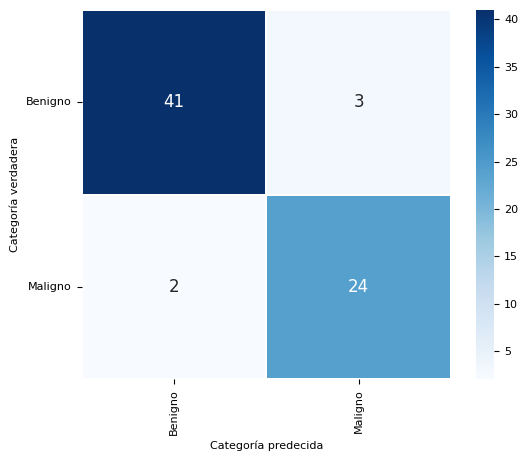

Valores de métricas obtenidas con clase positiva Maligno:
precision: 0.8888888888888888
recall: 0.9230769230769231
f1-score: 0.9056603773584906
accuracy: 0.9285714285714286
error: 0.0714285714285714
specificity: 0.9318181818181818
false positive rate: 0.06818181818181823
auc: 0.9274475524475525


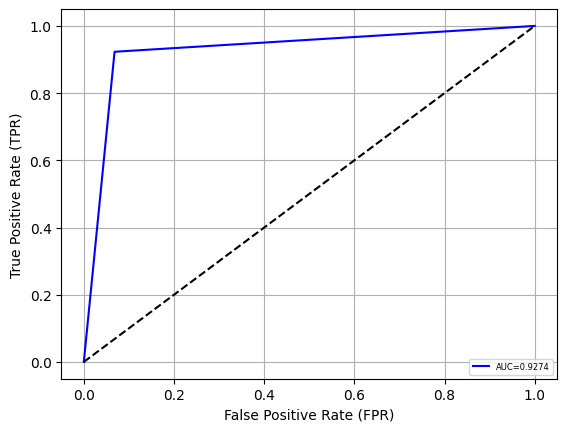

----------------------------------------------------
Resultados para Fold Nro. 2
----------------------------------------------------
Matriz de confusión


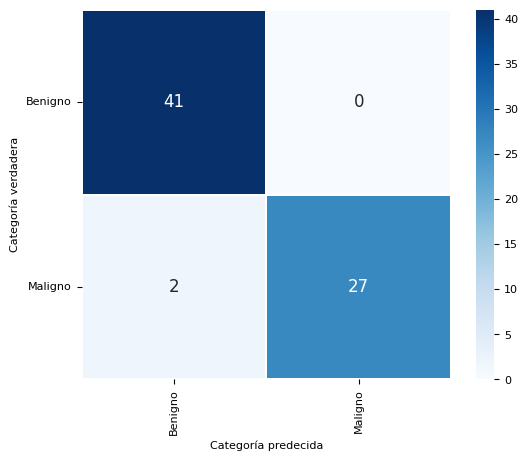

Valores de métricas obtenidas con clase positiva Maligno:
precision: 1.0
recall: 0.9310344827586207
f1-score: 0.9642857142857143
accuracy: 0.9714285714285714
error: 0.02857142857142858
specificity: 1.0
false positive rate: 0.0
auc: 0.9655172413793103


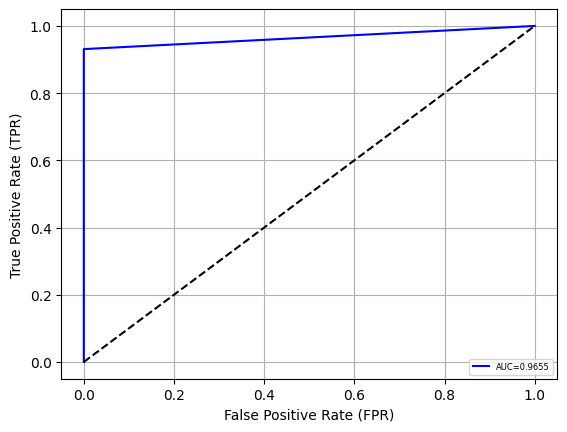

----------------------------------------------------
Resultados para Fold Nro. 3
----------------------------------------------------
Matriz de confusión


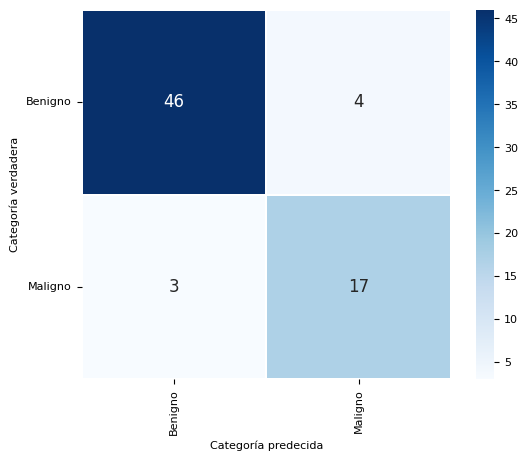

Valores de métricas obtenidas con clase positiva Maligno:
precision: 0.8095238095238095
recall: 0.85
f1-score: 0.8292682926829269
accuracy: 0.9
error: 0.09999999999999998
specificity: 0.92
false positive rate: 0.07999999999999996
auc: 0.8850000000000001


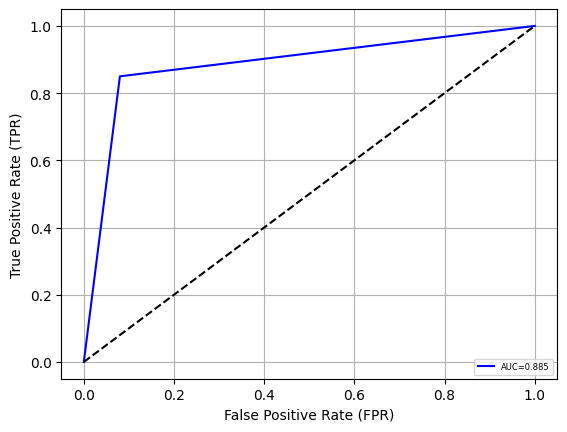

----------------------------------------------------
Resultados para Fold Nro. 4
----------------------------------------------------
Matriz de confusión


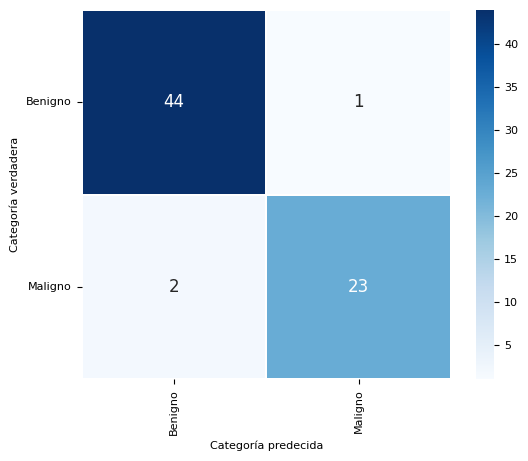

Valores de métricas obtenidas con clase positiva Maligno:
precision: 0.9583333333333334
recall: 0.92
f1-score: 0.9387755102040817
accuracy: 0.9571428571428572
error: 0.042857142857142816
specificity: 0.9777777777777777
false positive rate: 0.022222222222222254
auc: 0.9488888888888889


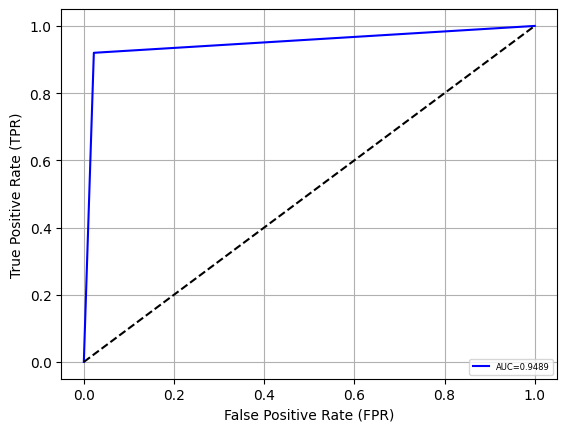

----------------------------------------------------
Resultados para Fold Nro. 5
----------------------------------------------------
Matriz de confusión


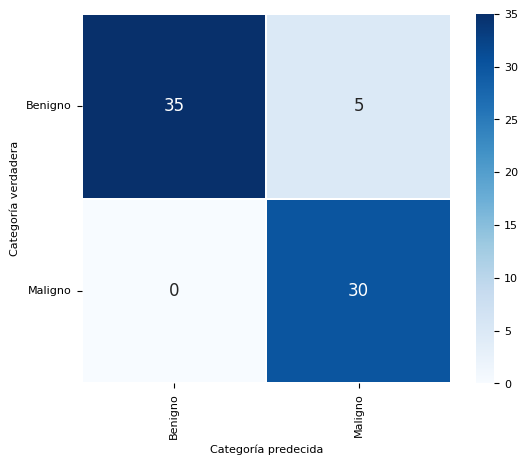

Valores de métricas obtenidas con clase positiva Maligno:
precision: 0.8571428571428571
recall: 1.0
f1-score: 0.923076923076923
accuracy: 0.9285714285714286
error: 0.0714285714285714
specificity: 0.875
false positive rate: 0.125
auc: 0.9375


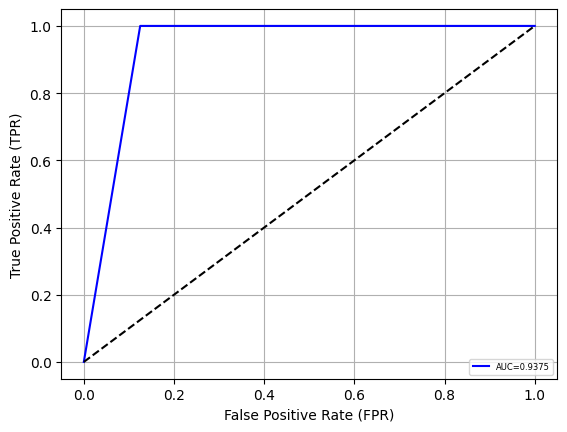

----------------------------------------------------
Resultados para Fold Nro. 6
----------------------------------------------------
Matriz de confusión


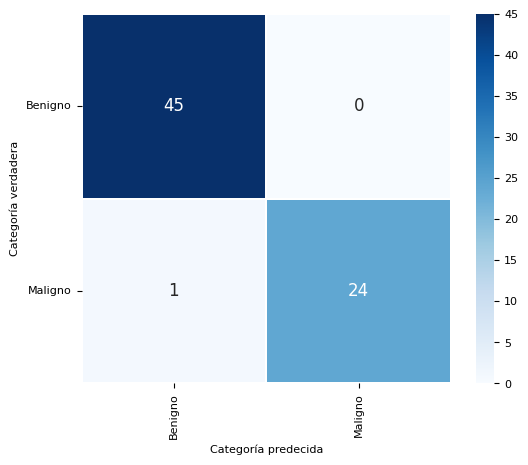

Valores de métricas obtenidas con clase positiva Maligno:
precision: 1.0
recall: 0.96
f1-score: 0.9795918367346939
accuracy: 0.9857142857142858
error: 0.014285714285714235
specificity: 1.0
false positive rate: 0.0
auc: 0.98


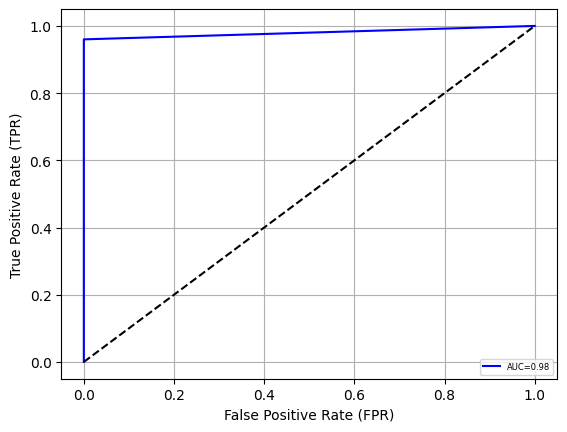

----------------------------------------------------
Resultados para Fold Nro. 7
----------------------------------------------------
Matriz de confusión


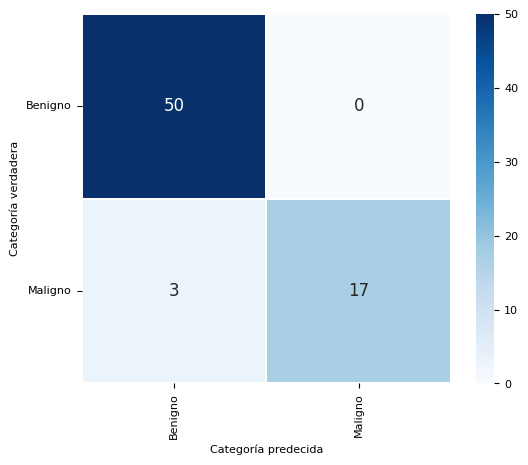

Valores de métricas obtenidas con clase positiva Maligno:
precision: 1.0
recall: 0.85
f1-score: 0.9189189189189189
accuracy: 0.9571428571428572
error: 0.042857142857142816
specificity: 1.0
false positive rate: 0.0
auc: 0.925


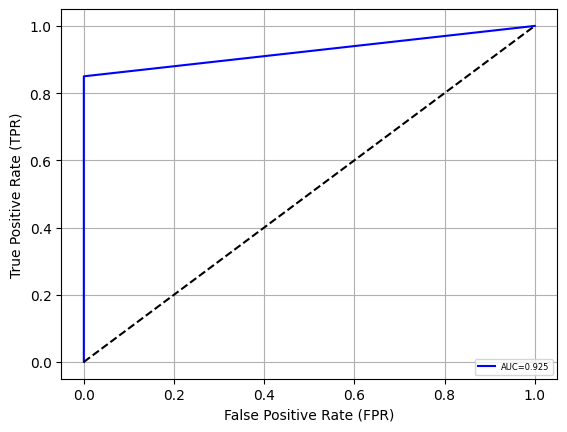

----------------------------------------------------
Resultados para Fold Nro. 8
----------------------------------------------------
Matriz de confusión


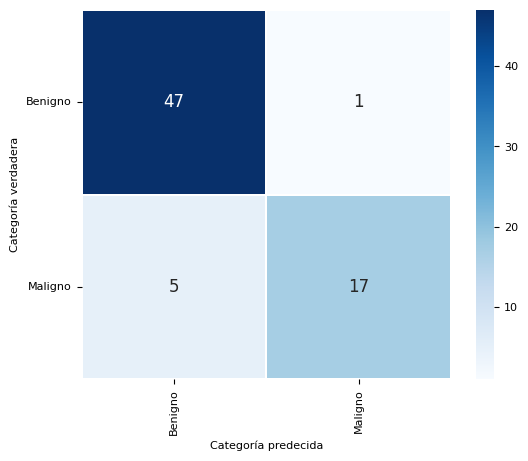

Valores de métricas obtenidas con clase positiva Maligno:
precision: 0.9444444444444444
recall: 0.7727272727272727
f1-score: 0.85
accuracy: 0.9142857142857143
error: 0.08571428571428574
specificity: 0.9791666666666666
false positive rate: 0.02083333333333337
auc: 0.8759469696969696


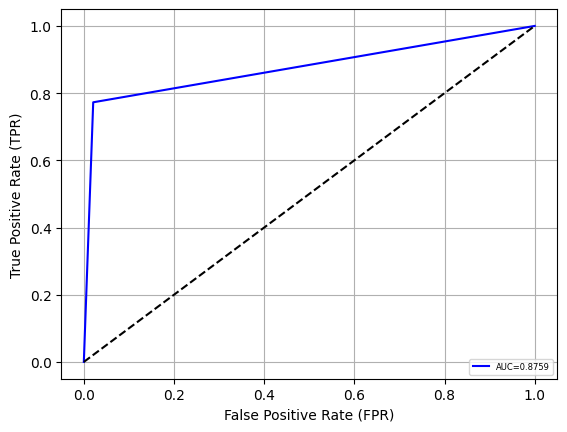

----------------------------------------------------
Resultados para Fold Nro. 9
----------------------------------------------------
Matriz de confusión


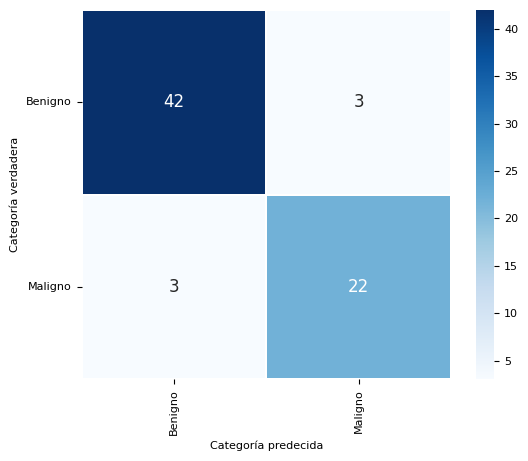

Valores de métricas obtenidas con clase positiva Maligno:
precision: 0.88
recall: 0.88
f1-score: 0.88
accuracy: 0.9142857142857143
error: 0.08571428571428574
specificity: 0.9333333333333333
false positive rate: 0.06666666666666665
auc: 0.9066666666666666


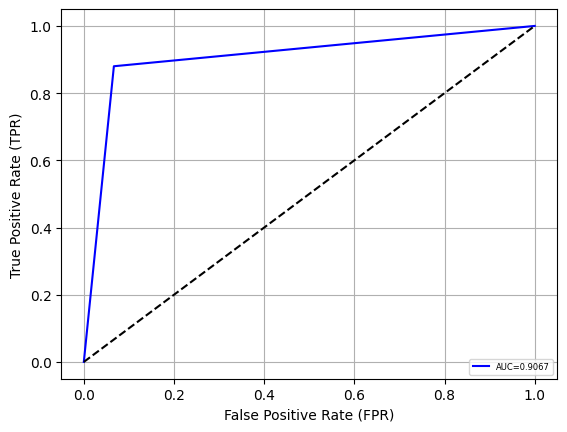

----------------------------------------------------
Resultados para Fold Nro. 10
----------------------------------------------------
Matriz de confusión


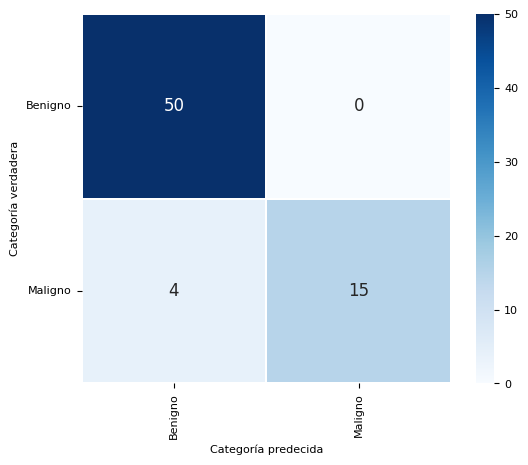

Valores de métricas obtenidas con clase positiva Maligno:
precision: 1.0
recall: 0.7894736842105263
f1-score: 0.8823529411764706
accuracy: 0.9420289855072463
error: 0.05797101449275366
specificity: 1.0
false positive rate: 0.0
auc: 0.8947368421052632


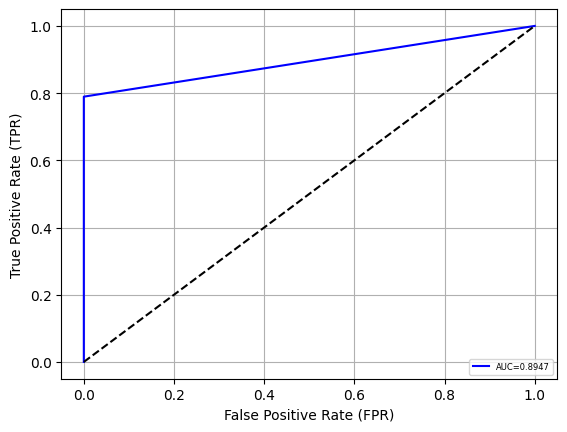


----------------------------------------------------
Resultado final matriz de métricas obtenidas:
Filas (Métrica) vs Columnas (Nro. de fold)
----------------------------------------------------
[[0.88888889 1.         0.80952381 0.95833333 0.85714286 1.
  1.         0.94444444 0.88       1.        ]
 [0.92307692 0.93103448 0.85       0.92       1.         0.96
  0.85       0.77272727 0.88       0.78947368]
 [0.90566038 0.96428571 0.82926829 0.93877551 0.92307692 0.97959184
  0.91891892 0.85       0.88       0.88235294]
 [0.92857143 0.97142857 0.9        0.95714286 0.92857143 0.98571429
  0.95714286 0.91428571 0.91428571 0.94202899]
 [0.07142857 0.02857143 0.1        0.04285714 0.07142857 0.01428571
  0.04285714 0.08571429 0.08571429 0.05797101]
 [0.93181818 1.         0.92       0.97777778 0.875      1.
  1.         0.97916667 0.93333333 1.        ]
 [0.06818182 0.         0.08       0.02222222 0.125      0.
  0.         0.02083333 0.06666667 0.        ]
 [0.92744755 0.96551724 0.885

In [3]:
# K-fold cross validation (10 iteraciones)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
num_metricas = 8
metricas = np.array([], dtype=np.int64).reshape(num_metricas,0)

# Obtenemos los índices de aquellas observaciones que corresponden a entrenamiento
# y test y realizamos las correspondientes iteraciones
for i, (train_index, test_index) in enumerate(kfold.split(x)):
  print("----------------------------------------------------")
  print("Resultados para Fold Nro.",str(i+1))
  print("----------------------------------------------------")
  # Definición y entrenamiento de árbol de decisión
  modelo = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
  modelo.fit(x[train_index],y[train_index])
  # Obtención de etiquetas verdaderas y predecidas para la iteración
  ytrue = y[test_index]
  ypred = modelo.predict(x[test_index])
  # Obtenemos las métricas para la iteración
  resultado = calcularMetricas(ytrue, ypred)
  metricas = np.hstack((metricas,resultado))

# Matriz con resultados de métricas
# Filas: Denota cada métrica (precision, recall, etc)
# Columnas: Número de k-fold (iteración)
print("")
print("----------------------------------------------------")
print("Resultado final matriz de métricas obtenidas:")
print("Filas (Métrica) vs Columnas (Nro. de fold)")
print("----------------------------------------------------")
print(metricas)
print("")
print("----------------------------------------------------")
print("Se computa la media total para cada métrica:")
print("----------------------------------------------------")
totales = np.mean(metricas,1).reshape(num_metricas,-1)
print("mean-precision:",totales[0,0])
print("mean-recall:",totales[1,0])
print("mean-f1-score:",totales[2,0])
print("mean-accuracy:",totales[3,0])
print("mean-error:",totales[4,0])
print("mean-specificity:",totales[5,0])
print("mean-false positive rate:",totales[6,0])
print("mean-auc:",totales[7,0])
